In [1]:
!pip install pandas numpy matplotlib scikit-learn tqdm




[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.utils import resample

In [4]:
root_folder = r'C:\\Users\\LENOVO\\Desktop\\Aiml-Ca'  

# Find all CSV files
all_files = glob.glob(os.path.join(root_folder, '**', '*.csv'), recursive=True)

print(f"Total CSV files found: {len(all_files)}")
for file in all_files:
    print(file)

Total CSV files found: 85
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\demonstrate_structure.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\ack.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\benign_traffic.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\combo.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\junk.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\scan.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\syn.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\tcp.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\udp.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Danmini_Doorbell\udpplain.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Ecobee_Thermostat\ack.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Ecobee_Thermostat\benign_traffic.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Ecobee_Thermostat\combo.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Ecobee_Thermostat\junk.csv
C:\\Users\\LENOVO\\Desktop\\Aiml-Ca\Ecobee_Thermostat\scan.csv
C:\\Users\\LENOVO\

In [5]:
unique_columns = set()

for file in all_files:
    try:
        df_temp = pd.read_csv(file, nrows=1)  
        unique_columns.update(df_temp.columns.tolist())
    except Exception as e:
        print(f"Error reading {file}: {e}")

print(f"\nUnique columns found across all CSV files ({len(unique_columns)} columns):")
for col in sorted(unique_columns):
    print(col)



Unique columns found across all CSV files (115 columns):
HH_L0.01_covariance
HH_L0.01_magnitude
HH_L0.01_mean
HH_L0.01_pcc
HH_L0.01_radius
HH_L0.01_std
HH_L0.01_weight
HH_L0.1_covariance
HH_L0.1_magnitude
HH_L0.1_mean
HH_L0.1_pcc
HH_L0.1_radius
HH_L0.1_std
HH_L0.1_weight
HH_L1_covariance
HH_L1_magnitude
HH_L1_mean
HH_L1_pcc
HH_L1_radius
HH_L1_std
HH_L1_weight
HH_L3_covariance
HH_L3_magnitude
HH_L3_mean
HH_L3_pcc
HH_L3_radius
HH_L3_std
HH_L3_weight
HH_L5_covariance
HH_L5_magnitude
HH_L5_mean
HH_L5_pcc
HH_L5_radius
HH_L5_std
HH_L5_weight
HH_jit_L0.01_mean
HH_jit_L0.01_variance
HH_jit_L0.01_weight
HH_jit_L0.1_mean
HH_jit_L0.1_variance
HH_jit_L0.1_weight
HH_jit_L1_mean
HH_jit_L1_variance
HH_jit_L1_weight
HH_jit_L3_mean
HH_jit_L3_variance
HH_jit_L3_weight
HH_jit_L5_mean
HH_jit_L5_variance
HH_jit_L5_weight
H_L0.01_mean
H_L0.01_variance
H_L0.01_weight
H_L0.1_mean
H_L0.1_variance
H_L0.1_weight
H_L1_mean
H_L1_variance
H_L1_weight
H_L3_mean
H_L3_variance
H_L3_weight
H_L5_mean
H_L5_variance
H_L5

In [6]:
from tqdm import tqdm  # progress bar

# Define important columns to load
selected_features = [
    'HH_L0.01_mean', 'HH_L0.1_mean', 'HH_L1_mean',
    'HH_L0.01_std', 'HH_L0.1_std', 'HH_L1_std',
    'HH_L0.01_covariance', 'HH_L0.1_covariance', 'HH_L1_covariance',
    'HH_L0.01_weight', 'HH_L0.1_weight', 'HH_L1_weight'
]

data_list = []

for csv_file in tqdm(all_files, desc="Loading files"):
    try:
        df = pd.read_csv(csv_file, usecols=selected_features, nrows=10000)  # Only load useful columns and only first 10,000 rows
        
        if df.empty:
            continue
        
        if 'benign' in os.path.basename(csv_file).lower():
            df['label'] = 0
        else:
            df['label'] = 1
        
        data_list.append(df)
    except Exception as e:
        print(f"Error reading {csv_file}: {e}")

# Merge all data
full_data = pd.concat(data_list, ignore_index=True)
full_data = full_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Done loading! Total samples: {full_data.shape[0]}")



Loading files: 100%|███████████████████████████| 85/85 [00:08<00:00,  9.65it/s]


Done loading! Total samples: 840000


In [7]:
# Select a few good features
selected_features = [
    'HH_L0.01_mean', 'HH_L0.1_mean', 'HH_L1_mean',
    'HH_L0.01_std', 'HH_L0.1_std', 'HH_L1_std',
    'HH_L0.01_covariance', 'HH_L0.1_covariance', 'HH_L1_covariance',
    'HH_L0.01_weight', 'HH_L0.1_weight', 'HH_L1_weight'
]


# Check if features exist
for feat in selected_features:
    if feat not in full_data.columns:
        raise ValueError(f"Feature {feat} not found in dataset!")

X = full_data[selected_features]
y = full_data['label']


In [8]:
#scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
 #Step 5: Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)


In [10]:
# Step 6: Signature-Based Detection (Simulated)

threshold_mean = 0.4
threshold_std = 0.4
threshold_cov = 0.3

# Signature: combine multiple traffic statistics
full_data['signature_alert'] = (
    ((full_data['HH_L0.01_mean'] > threshold_mean) & (full_data['HH_L0.01_std'] > threshold_std)) |
    ((full_data['HH_L0.1_mean'] > threshold_mean) & (full_data['HH_L0.1_std'] > threshold_std)) |
    ((full_data['HH_L1_mean'] > threshold_mean) & (full_data['HH_L1_std'] > threshold_std)) |
    ((full_data['HH_L0.01_covariance'] > threshold_cov) | (full_data['HH_L0.1_covariance'] > threshold_cov))
).astype(int)



In [11]:
# Step 7: Anomaly Detection using Isolation Forest

X_sampled, y_sampled = resample(X_scaled, y, n_samples=50000, random_state=42)

anomaly_detector = IsolationForest(contamination=0.05, random_state=42)  # Increase contamination
anomaly_detector.fit(X_scaled)


anomaly_preds = anomaly_detector.predict(X_scaled)
full_data['anomaly_alert'] = (anomaly_detector.predict(X_scaled) == -1).astype(int)

In [12]:
# Step 8: Hybrid Detection (Signature OR Anomaly)
full_data['hybrid_alert'] = (
    (full_data['signature_alert'] == 1) | (full_data['anomaly_alert'] == 1)
).astype(int)


In [13]:

print(full_data['label'].unique())
print(full_data['hybrid_alert'].unique())


[1 0]
[0 1]


In [14]:
print("\nHybrid Detection Results:")
print(confusion_matrix(full_data['label'], full_data['hybrid_alert']))
print(classification_report(full_data['label'], full_data['hybrid_alert'], digits=4))


Hybrid Detection Results:
[[ 37749  62251]
 [603659 136341]]
              precision    recall  f1-score   support

           0     0.0589    0.3775    0.1018    100000
           1     0.6865    0.1842    0.2905    740000

    accuracy                         0.2072    840000
   macro avg     0.3727    0.2809    0.1962    840000
weighted avg     0.6118    0.2072    0.2681    840000



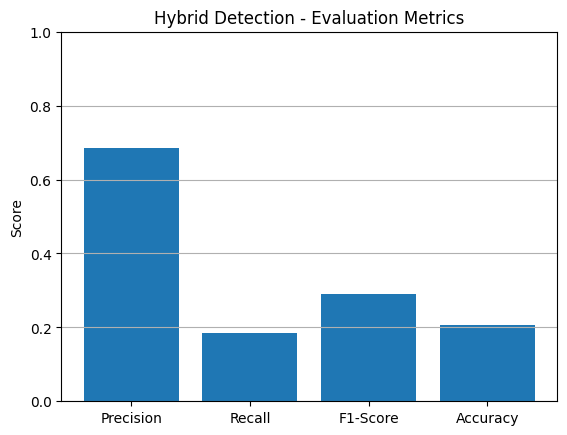

In [15]:
# Evaluation for Hybrid Detection
precision = precision_score(full_data['label'], full_data['hybrid_alert'])
recall = recall_score(full_data['label'], full_data['hybrid_alert'])
f1 = f1_score(full_data['label'], full_data['hybrid_alert'])
accuracy = accuracy_score(full_data['label'], full_data['hybrid_alert'])

metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': accuracy}

plt.figure()
plt.bar(metrics.keys(), metrics.values())
plt.title('Hybrid Detection - Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [16]:
# Step 9: Supervised Learning - Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

In [17]:
# Evaluation
print("Random Forest Model Results:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

Random Forest Model Results:
[[ 29946     54]
 [     9 221991]]
              precision    recall  f1-score   support

           0     0.9997    0.9982    0.9989     30000
           1     0.9998    1.0000    0.9999    222000

    accuracy                         0.9998    252000
   macro avg     0.9997    0.9991    0.9994    252000
weighted avg     0.9997    0.9998    0.9997    252000



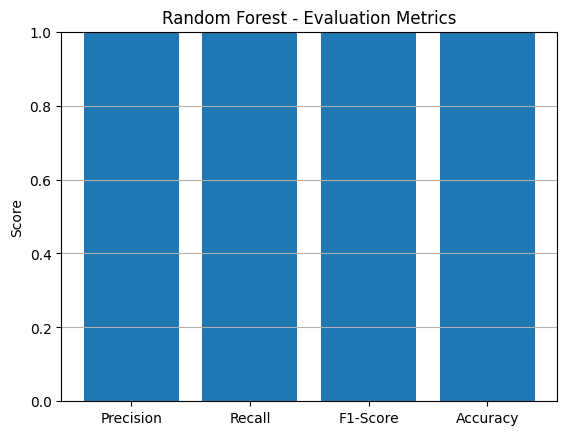

In [18]:
# Evaluation for Random Forest
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

metrics = {'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'Accuracy': accuracy}

plt.figure()
plt.bar(metrics.keys(), metrics.values())
plt.title('Random Forest - Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


 Supervised Federated Learning Results:
[[ 29935     65]
 [    28 221972]]
              precision    recall  f1-score   support

           0     0.9991    0.9978    0.9984     30000
           1     0.9997    0.9999    0.9998    222000

    accuracy                         0.9996    252000
   macro avg     0.9994    0.9989    0.9991    252000
weighted avg     0.9996    0.9996    0.9996    252000



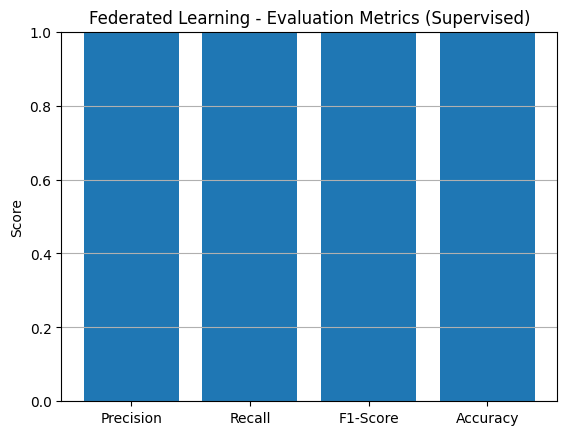

In [19]:

# Step 10: Federated Learning Simulation
num_clients = 3

# Split only training data among clients
client_data = np.array_split(X_train, num_clients)
client_labels = np.array_split(y_train, num_clients)

client_models = []

# Train RandomForestClassifier at each client
for idx in range(num_clients):
    clf = RandomForestClassifier(n_estimators=100, random_state=idx)
    clf.fit(client_data[idx], client_labels[idx])
    client_models.append(clf)

# Clients predict on common test data
votes = np.zeros((X_test.shape[0], num_clients))

for idx, model in enumerate(client_models):
    client_preds = model.predict(X_test)
    votes[:, idx] = client_preds

# Majority voting
federated_preds = (votes.sum(axis=1) >= (num_clients / 2)).astype(int)

# Evaluation
print("\n Supervised Federated Learning Results:")
print(confusion_matrix(y_test, federated_preds))
print(classification_report(y_test, federated_preds, digits=4))

# Plotting Federated Learning Metrics
fed_precision = precision_score(y_test, federated_preds)
fed_recall = recall_score(y_test, federated_preds)
fed_f1 = f1_score(y_test, federated_preds)
fed_accuracy = accuracy_score(y_test, federated_preds)

fed_metrics = {'Precision': fed_precision, 'Recall': fed_recall, 'F1-Score': fed_f1, 'Accuracy': fed_accuracy}

plt.figure()
plt.bar(fed_metrics.keys(), fed_metrics.values())
plt.title('Federated Learning - Evaluation Metrics (Supervised)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()